## Neural Networks

In this example we train a neural network from scratch to detect handwritten digits. We use [PyTorch]{https://pytorch.org/} instead of scikit-learn to define our network because it gives us better control over the structure of the network and the training loop. Note that neural networks are really useful in both supervised and unsuperised machine learning regimes. In this example we use a neural network to address a supervised learning problem.

In [ ]:
# Import some libraries
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Download the train-test split of the data
train = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



What does the data look like?

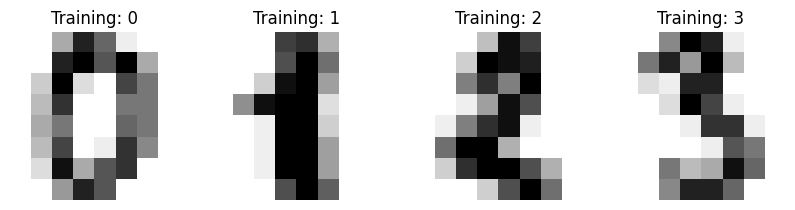

In [ ]:
from sklearn import datasets

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

Batch both the training and the testing data, for a given batch size.

In [ ]:
batch_size = 500

trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

Now that our data is ready, we need to define a network. We define a network with two hidden layers of 64 neurons each.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Layer (we have 28x28 pixels)
        self.input = nn.Linear(28*28, 16)

        # Hidden layers
        self.hidden1 = nn.Linear(16, 16)
        self.hidden2 = nn.Linear(16, 16)

        # Output layer (we are classifying digits between 0 and 9)
        self.output = nn.Linear(16, 10)

    def forward(self, x):
        # We use ReLu activation function on all layers
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)

        # We apply log softmax to the output
        return F.log_softmax(x, dim=1)

# Define the network
net = Net()

# Print the network we have just defined (note that this network has all the weights and biases randomly initialised)
print(net)

Net(
  (input): Linear(in_features=784, out_features=16, bias=True)
  (hidden1): Linear(in_features=16, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
)


Now that we have both the data and the network we want to train it. We use the CrossEntropyLoss (which is the usual loss function for multi-classification problems) and the Adam optimizer with learning rate `0.001`.

In [ ]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Then, we go through the running loop, passing through the whole training set multiple times (for the specified number of epochs). Every 100 steps we evaluate on testing to see whether we are overfitting (by printing both the loss on training and testing).

In [ ]:
# Set the number of epochs
n_epochs = 10

# To record the loss
losses = []

i = 0
# Loops over the number of epochs
for epoch in range(n_epochs):
    # Loop over the data in batches
    for data in trainset:
        # Upacks features and labels of the data
        X, y = data

        # Set gradients to zero
        net.zero_grad()

        # Passes the data through the network
        output = net(X.view(-1,28*28))

        # Loss calculation
        loss = loss_function(output, y)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()
        i+=1

        # Every 100 steps print the loss for each batch: it should go down if it is learning (and record it for plotting)
        if i%100==0:
            print(f'Loss at epoch {epoch} and step {i}: ', loss.item())
            losses.append(loss.item())


Loss at epoch 0 and step 100:  0.3323073983192444
Loss at epoch 1 and step 200:  0.4004277288913727
Loss at epoch 2 and step 300:  0.31792908906936646
Loss at epoch 3 and step 400:  0.3205946981906891
Loss at epoch 4 and step 500:  0.2252173125743866
Loss at epoch 4 and step 600:  0.2872476577758789
Loss at epoch 5 and step 700:  0.21079237759113312
Loss at epoch 6 and step 800:  0.24695266783237457
Loss at epoch 7 and step 900:  0.22486011683940887
Loss at epoch 8 and step 1000:  0.17593708634376526
Loss at epoch 9 and step 1100:  0.21664603054523468
Loss at epoch 9 and step 1200:  0.20534253120422363


We can visualise the change in the loss through training by plotting them (this is called learning curve).

Text(0, 0.5, 'loss')

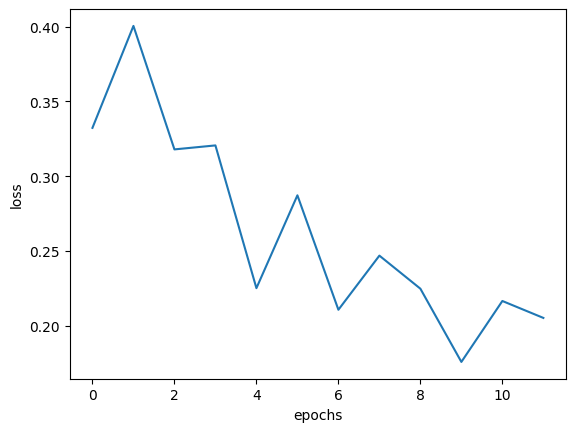

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('loss')


After training the model, we can compute the accuracy on unseen data (the testing data).

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.936
